In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import requests
import csv
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [2]:
# Mount Google Drive to access files
from google.colab import drive

# Define the directory on Google Drive to save and load data/models
drive.mount('/content/drive')
drive_dir = "drive/MyDrive/SI_4lab/1D"
os.makedirs(drive_dir, exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(69)
tf.random.set_seed(69)

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Function to prepare the data for training and testing
def prepare_data(session_num=1, num_users=30, test_size=0.1, val_size=0.1):
    """
    Loads, preprocesses, and splits the data into training, validation, and test sets.

    Args:
        session_num (int): The session number to use (default is 1).
        num_users (int): The number of users to include (default is 30).
        test_size (float): The proportion of the dataset to include in the test split (default is 0.1).
        val_size (float): The proportion of the dataset to include in the validation split (default is 0.1).

    Returns:
        tuple: Contains X_train, X_val, X_test, y_train, y_val, y_test, and user_mapping.
    """
    # Load the data from a CSV file
    data = pd.read_csv(f"{drive_dir}/data.csv")

    # Filter data for the specified session
    data = data[data['sessionIndex'] == session_num]

    # Select data for a specified number of users
    unique_users = data['subject'].unique()
    selected_users = unique_users[:num_users]
    data = data[data['subject'].isin(selected_users)]

    # Map user IDs to numerical labels
    user_mapping = {user: idx for idx, user in enumerate(selected_users)}
    data['label'] = data['subject'].map(user_mapping)

    # Separate features (X) and labels (y)
    X = data.drop(['subject', 'sessionIndex', 'rep', 'label'], axis=1)
    y = data['label']

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Reshape X for the 1D CNN model (samples, timesteps, features)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split data into training, validation, and test sets
    # First split into temporary (train+val) and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Adjust validation size proportion relative to the temporary set
    val_size_adjusted = val_size / (1 - test_size)
    # Split temporary set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size_adjusted, stratify=y_temp, random_state=42)

    # Convert labels to one-hot encoding for categorical crossentropy loss
    y_train = to_categorical(y_train, num_classes=num_users)
    y_val = to_categorical(y_val, num_classes=num_users)
    y_test = to_categorical(y_test, num_classes=num_users)

    return X_train, X_val, X_test, y_train, y_val, y_test, user_mapping

In [ ]:
# Function to create a 1D CNN model with flexible architecture and hyperparameters
def create_model(input_shape, num_classes, architecture='simple', dropout_rate=0.5,
               activation='relu', use_batch_norm=False, kernel_size=3,
               num_filters=32, pool_size=2, learning_rate=0.001, optimizer_name='adam'):
    """
    Creates a 1D Convolutional Neural Network model.

    Args:
        input_shape (tuple): The shape of the input data (timesteps, features).
        num_classes (int): The number of output classes.
        architecture (str): The complexity of the model ('simple', 'medium', or 'complex').
        dropout_rate (float): The dropout rate to apply.
        activation (str): The activation function to use in hidden layers.
        use_batch_norm (bool): Whether to include Batch Normalization layers.
        kernel_size (int): The size of the convolutional kernel.
        num_filters (int): The initial number of filters in the convolutional layers.
        pool_size (int): The size of the max pooling window.
        learning_rate (float): The learning rate for the optimizer.
        optimizer_name (str): The name of the optimizer ('adam', 'sgd', or 'rmsprop').

    Returns:
        keras.Model: The compiled TensorFlow Keras model.
    """
    # Define the architecture configurations
    configs = {
        'simple': {
            'conv_layers': 1,
            'dense_layers': [50]
        },
        'medium': {
            'conv_layers': 2,
            'dense_layers': [100]
        },
        'complex': {
            'conv_layers': 3,
            'dense_layers': [200, 100]
        }
    }


    # Select the configuration based on the chosen architecture
    config = configs.get(architecture, configs['simple'])

    # Initialize a sequential model
    model = Sequential()

    # Add the input layer
    model.add(Input(shape=input_shape))

    # Add convolutional layers
    for i in range(config['conv_layers']):
        model.add(Conv1D(filters=num_filters * (2**i), kernel_size=kernel_size, activation=activation))

        if use_batch_norm:
            model.add(BatchNormalization())

        model.add(MaxPooling1D(pool_size=pool_size))

        # Only add dropout after final conv layer
        if i == config['conv_layers'] - 1 and dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Flatten())

    # Add dense layers
    for units in config['dense_layers']:
        model.add(Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Configure optimizer
    optimizers = {
        'adam': Adam(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate)
    }
    optimizer = optimizers.get(optimizer_name, Adam(learning_rate=learning_rate))

    # Compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Function to train the CNN model
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """
    Trains the given Keras model.

    Args:
        model (keras.Model): The model to train.
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels (one-hot encoded).
        X_val (np.ndarray): Validation features.
        y_val (np.ndarray): Validation labels (one-hot encoded).
        epochs (int): The number of epochs to train for (default is 50).
        batch_size (int): The batch size to use during training (default is 32).

    Returns:
        keras.callbacks.History: The history object containing training progress.
    """
    # Define Early Stopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Define Model Checkpoint callback to save the best model based on validation accuracy
    checkpoint = ModelCheckpoint(f'{drive_dir}/best_model.keras', monitor='val_accuracy',
                                save_best_only=True, mode='max', verbose=0)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    return history

In [ ]:
# Function to perform hyperparameter experiments
def experiment_hyperparameter(
    X_train, y_train, X_val, y_val, input_shape, num_classes, param_name, param_values,
    architecture='simple', dropout_rate=0.5, use_batch_norm=False,
    activation='relu', optimizer_name='adam'
):
    """
    Runs experiments to compare different values of a single hyperparameter.

    Args:
        X_train, y_train, X_val, y_val: Training and validation data.
        input_shape (tuple): Input shape of the model.
        num_classes (int): Number of output classes.
        param_name (str): The name of the hyperparameter to experiment with.
        param_values (list): A list of values to test for the hyperparameter.
        architecture (str): Base architecture to use (default 'simple').
        dropout_rate (float): Base dropout rate (default 0.5).
        use_batch_norm (bool): Base batch normalization setting (default False).
        activation (str): Base activation function (default 'relu').
        optimizer_name (str): Base optimizer (default 'adam').

    Returns:
        tuple: A dictionary of results for each parameter value and the best performing value.
    """
    # Ensure the specified parameter name is supported
    assert param_name in ['architecture', 'dropout_rate', 'use_batch_norm', 'activation', 'optimizer_name'], "Unsupported parameter"
    results = {}

    # Iterate through each value of the hyperparameter
    for val in param_values:
        print(f"Training with {param_name}={val}...")

        # Define model parameters with the current hyperparameter value
        model_kwargs = {
            'input_shape': input_shape,
            'num_classes': num_classes,
            'architecture': architecture,
            'dropout_rate': dropout_rate,
            'use_batch_norm': use_batch_norm,
            'activation': activation,
            'optimizer_name': optimizer_name,
        }

        # Update the parameter we're testing
        model_kwargs[param_name] = val

        model = create_model(**model_kwargs)
        history = train_model(model, X_train, y_train, X_val, y_val)

        results[val] = {
            'model': model,
            'history': history,
            'val_accuracy': max(history.history['val_accuracy']),
            'val_loss': min(history.history['val_loss']),
        }

    # Plot the validation accuracy and loss for each parameter value
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for val in param_values:
        plt.plot(results[val]['history'].history['val_accuracy'], label=f'{param_name}={val}')
    plt.title(f'Validation accuracy comparison ({param_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for val in param_values:
        plt.plot(results[val]['history'].history['val_loss'], label=f'{param_name}={val}')
    plt.title(f'Validation loss comparison ({param_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Determine the best performing parameter value based on validation accuracy
    best_val = max(results, key=lambda x: results[x]['val_accuracy'])
    print(f"Best {param_name}: {best_val}")
    print(f"Validation accuracy: {results[best_val]['val_accuracy']:.4f}")
    print(f"Validation loss: {results[best_val]['val_loss']:.4f}")

    return results, best_val

In [ ]:
# Function to plot training and validation results
def plot_results(history, title=""):
    """
    Plots the training and validation accuracy and loss over epochs.

    Args:
        history (keras.callbacks.History): The history object from model training.
        title (str): An optional title for the plots.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation accuracy
    ax1.plot(history.history['accuracy'], label='Training accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation accuracy')
    ax1.set_title(f'Model accuracy {title}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot training and validation loss
    ax2.plot(history.history['loss'], label='Training loss')
    ax2.plot(history.history['val_loss'], label='Validation loss')
    ax2.set_title(f'Model loss {title}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Function to plot the confusion matrix and print classification report
def plot_confusion_matrix(y_true, y_pred, title=""):
    """
    Plots the confusion matrix and prints the classification report.

    Args:
        y_true (np.ndarray): True labels (one-hot encoded or numerical).
        y_pred (np.ndarray): Predicted labels (probabilities).
        title (str): An optional title for the confusion matrix plot.
    """
    # Convert one-hot encoded labels back to numerical labels
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # annot=True displays values, fmt='d' for integer format
    plt.title(f'Confusion matrix {title}')
    plt.xlabel('Predicted class')
    plt.ylabel('Actual class')
    plt.tight_layout()
    plt.show()

    # Print the classification report for detailed metrics (precision, recall, F1-score)
    print(classification_report(y_true, y_pred))

In [ ]:
# Function to save sample predictions with features to a CSV file
def save_sample_predictions(X_test, y_test, y_pred, num_classes, save_path):
    """
    Saves a sample of test predictions, actual labels, and corresponding features to a CSV file.
    Selects one sample per class if possible.

    Args:
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): True test labels (one-hot encoded).
        y_pred (np.ndarray): Predicted test labels (probabilities).
        num_classes (int): The total number of classes.
        save_path (str): The path to save the CSV file.
    """
    # Get true and predicted numerical labels
    true_labels = np.argmax(y_test, axis=1)
    predicted_labels = np.argmax(y_pred, axis=1)

    # Select one index per class to include in the sample
    selected_indices = []
    seen_classes = set()

    for idx, label in enumerate(true_labels):
        if label not in seen_classes:
            selected_indices.append(idx)
            seen_classes.add(label)
        if len(seen_classes) == num_classes:
            break # Stop once we have at least one sample from each class

    # Flatten the test features for saving to CSV
    X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1])

    # Define CSV headers
    feature_headers = [f"feature_{i}" for i in range(X_test_flat.shape[1])]
    csv_headers = ["Index", "Actual Label", "Predicted Label"] + feature_headers

    # Prepare rows for the CSV file
    csv_rows = [csv_headers]
    for idx in selected_indices:
        row = [idx, true_labels[idx], predicted_labels[idx]] + X_test_flat[idx].tolist()
        csv_rows.append(row)

    # Write the data to the CSV file
    with open(save_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_rows)

    print(f"Sample predictions with features saved to: {save_path}")


In [ ]:
# Function to create, train, and evaluate the best model based on hyperparameter tuning
def create_best_model(X_train, y_train, X_val, y_val, X_test, y_test, input_shape, num_classes,
                     architecture, dropout_rate, use_batch_norm, activation, optimizer):
    """
    Creates, trains, and evaluates the final best model using the identified optimal hyperparameters.

    Args:
        X_train, y_train, X_val, y_val, X_test, y_test: Data splits.
        input_shape (tuple): Input shape of the model.
        num_classes (int): Number of output classes.
        architecture (str): The best architecture found.
        dropout_rate (float): The best dropout rate found.
        use_batch_norm (bool): The best batch normalization setting found.
        activation (str): The best activation function found.
        optimizer (str): The best optimizer found.

    Returns:
        tuple: The trained best model and its training history.
    """
    print("Creating the best model with selected hyperparameters...")
    # Create the model using the best hyperparameters
    best_model = create_model(input_shape, num_classes, architecture=architecture,
                             dropout_rate=dropout_rate, use_batch_norm=use_batch_norm,
                             activation=activation, optimizer_name=optimizer)

    print("Training the best model...")
    # Train the best model
    history = train_model(best_model, X_train, y_train, X_val, y_val)

    # Plot training and validation results for the best model
    plot_results(history, f"(Best model: {architecture}, {activation}, {optimizer})")

    print("\nEvaluating the best model on the test set...")
    # Evaluate the best model on the test set
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
    print(f"Testing accuracy: {test_accuracy:.4f}")
    print(f"Testing loss: {test_loss:.4f}")

    print("\nGenerating predictions for the confusion matrix and sample data...")
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Plot the confusion matrix for the test set
    plot_confusion_matrix(y_test, y_pred, "Best model")

    # Save sample predictions with features to a CSV file
    save_sample_predictions(X_test, y_test, y_pred, num_classes, f"{drive_dir}/test_predictions_with_features.csv")

    return best_model, history

X_train shape: (1200, 31, 1)
X_val shape: (150, 31, 1)
X_test shape: (150, 31, 1)
y_train shape: (1200, 30)
y_val shape: (150, 30)
y_test shape: (150, 30)

EXPERIMENT NR.1: ARCHITECTURE COMPARISON
Training with architecture=simple...
Training with architecture=medium...
Training with architecture=complex...


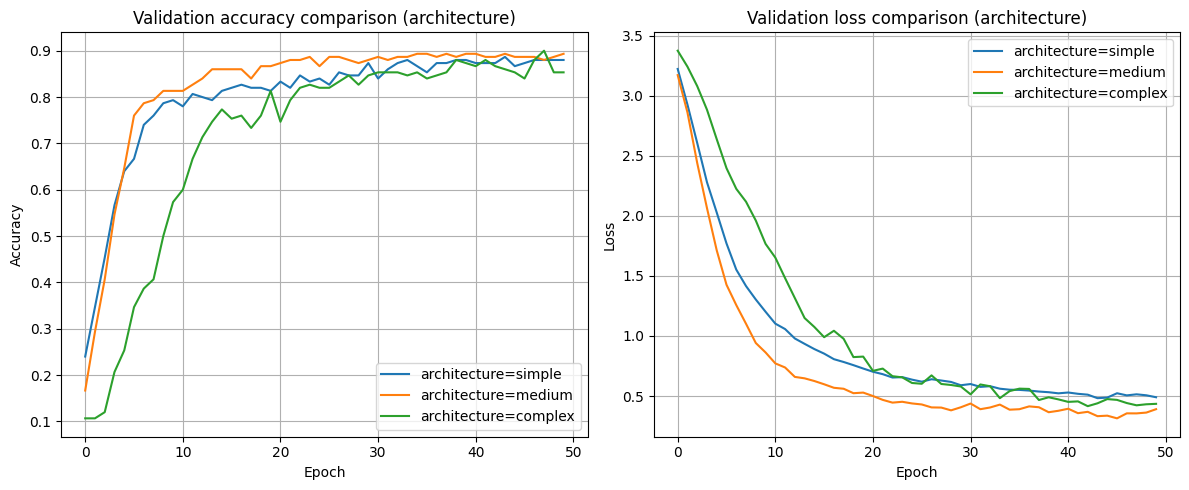

Best architecture: complex
Validation accuracy: 0.9000
Validation loss: 0.4155

EXPERIMENT NR.2: DROPOUT LAYERS COMPARISON
Training with dropout_rate=0.0...
Training with dropout_rate=0.2...
Training with dropout_rate=0.5...
Training with dropout_rate=0.7...


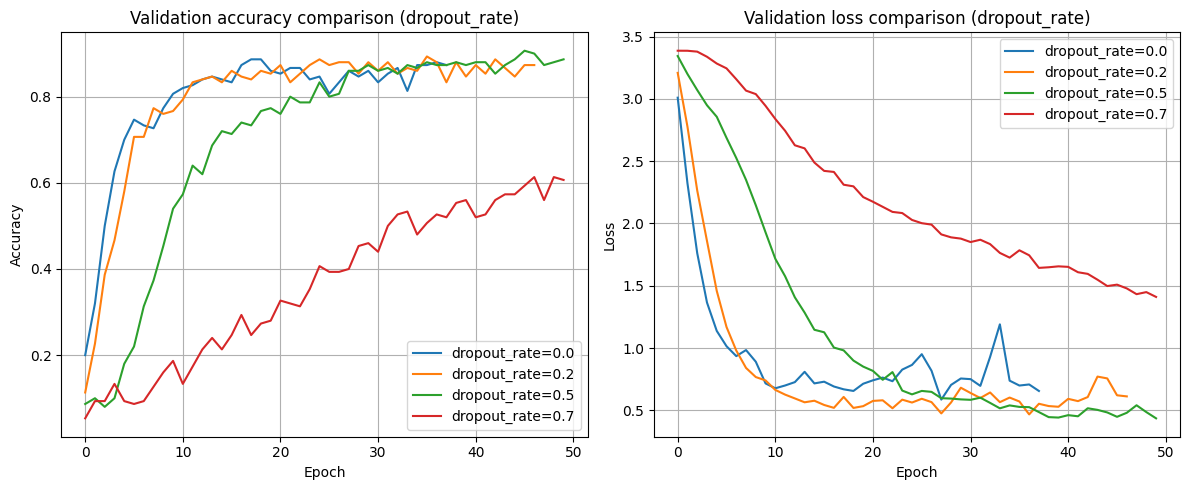

Best dropout_rate: 0.5
Validation accuracy: 0.9067
Validation loss: 0.4357

EXPERIMENT NR.3: BATCH NORMALISATION COMPARISON
Training with use_batch_norm=False...
Training with use_batch_norm=True...


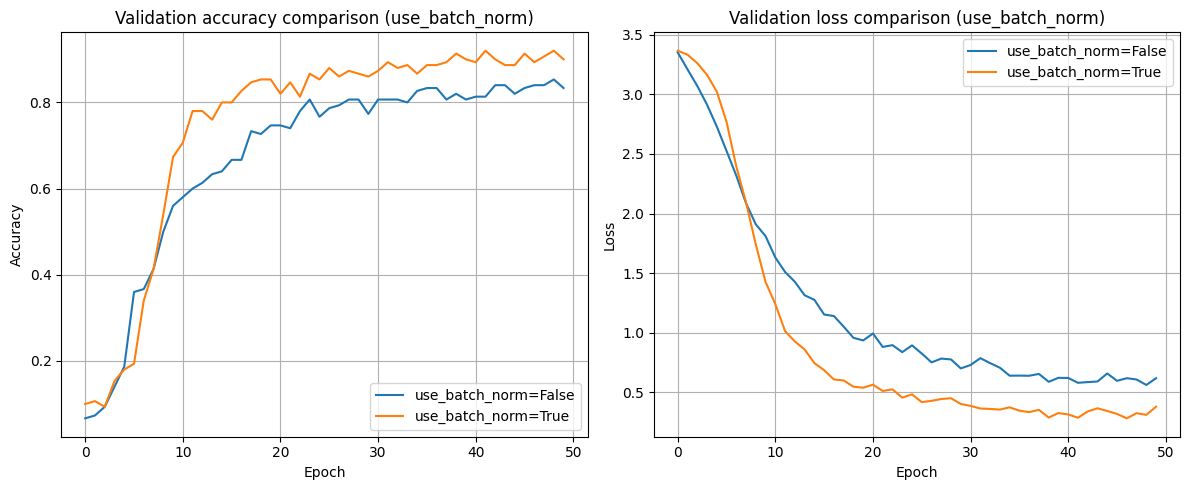

Best use_batch_norm: True
Validation accuracy: 0.9200
Validation loss: 0.2827

EXPERIMENT NR.4: ACTIVATION FUNCTIONS COMPARISON
Training with activation=relu...
Training with activation=tanh...
Training with activation=elu...
Training with activation=selu...


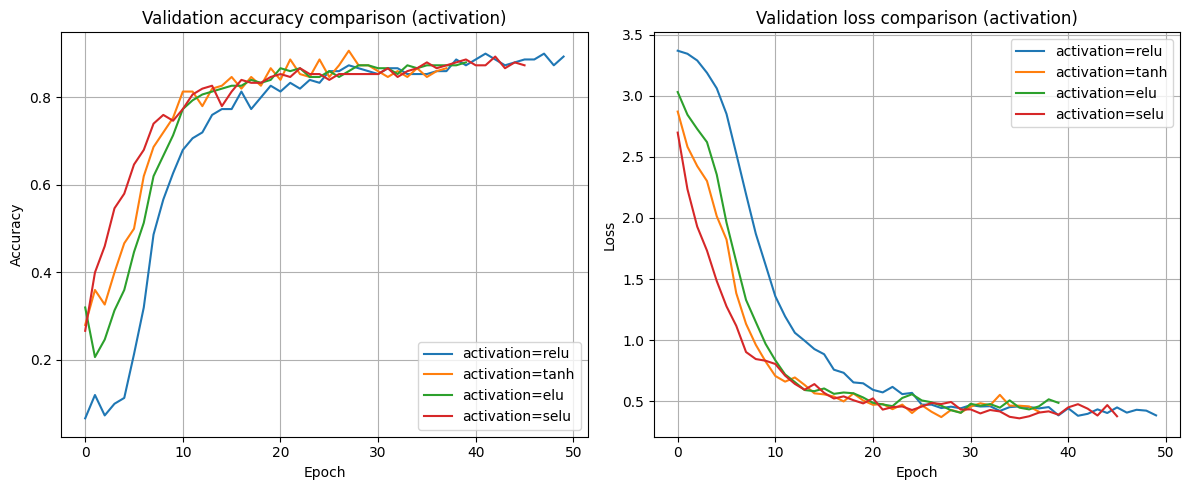

Best activation: tanh
Validation accuracy: 0.9067
Validation loss: 0.3688

EXPERIMENT NR.5: OPTIMIZER COMPARISON
Training with optimizer_name=adam...
Training with optimizer_name=sgd...
Training with optimizer_name=rmsprop...


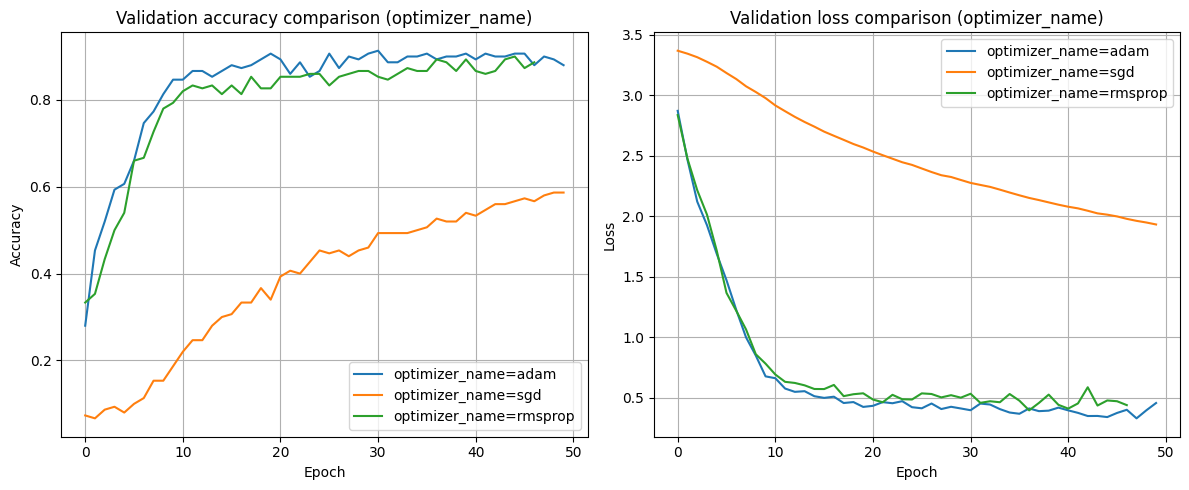

Best optimizer_name: adam
Validation accuracy: 0.9133
Validation loss: 0.3307

BEST MODEL TRAINING AND TESTING


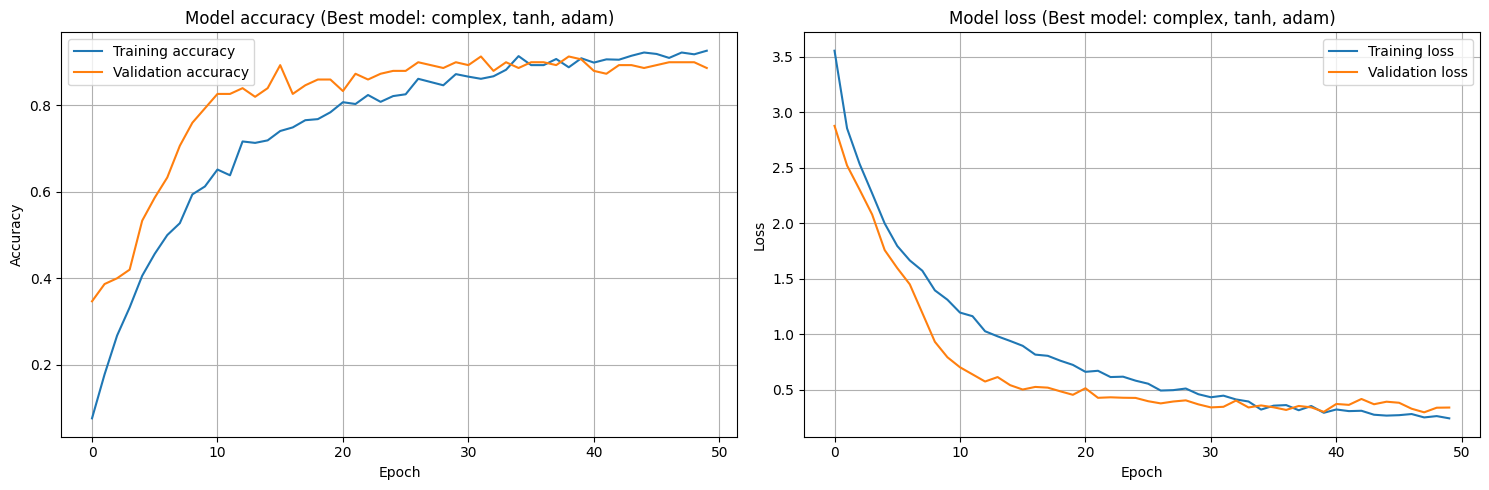

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9225 - loss: 0.2706
Testing accuracy: 0.9133
Testing loss: 0.2801
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


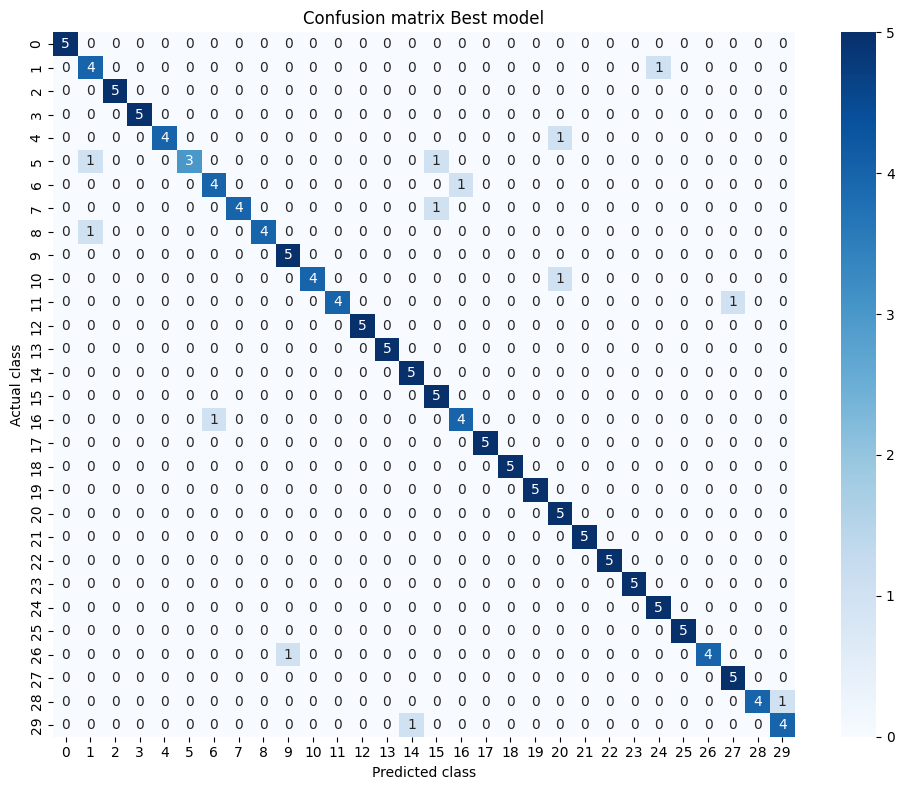

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.80      0.73         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       1.00      0.60      0.75         5
           6       0.80      0.80      0.80         5
           7       1.00      0.80      0.89         5
           8       1.00      0.80      0.89         5
           9       0.83      1.00      0.91         5
          10       1.00      0.80      0.89         5
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       0.83      1.00      0.91         5
          15       0.71      1.00      0.83         5
          16       0.80      0.80      0.80         5
          17       1.00    

In [ ]:
if __name__ == "__main__":
    X_train, X_val, X_test, y_train, y_val, y_test, user_mapping = prepare_data(
        session_num=1,
        num_users=30,
        test_size=0.1,
        val_size=0.1
    )

    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"y_test shape: {y_test.shape}")

    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = y_train.shape[1]

    print("\nEXPERIMENT NR.1: ARCHITECTURE COMPARISON")
    arch_results, best_arch = experiment_hyperparameter(X_train, y_train, X_val, y_val, input_shape, num_classes,
                          param_name='architecture', param_values=['simple', 'medium', 'complex'])

    print("\nEXPERIMENT NR.2: DROPOUT LAYERS COMPARISON")
    dropout_results, best_dropout = experiment_hyperparameter(X_train, y_train, X_val, y_val, input_shape, num_classes,
                          architecture=best_arch,
                          param_name='dropout_rate', param_values=[0.0, 0.2, 0.5, 0.7])

    print("\nEXPERIMENT NR.3: BATCH NORMALISATION COMPARISON")
    bn_results, best_bn = experiment_hyperparameter(X_train, y_train, X_val, y_val, input_shape, num_classes,
                          architecture=best_arch,
                          dropout_rate=best_dropout,
                          param_name='use_batch_norm', param_values=[False, True])

    print("\nEXPERIMENT NR.4: ACTIVATION FUNCTIONS COMPARISON")
    act_results, best_activation = experiment_hyperparameter(X_train, y_train, X_val, y_val, input_shape, num_classes,
                          architecture=best_arch,
                          dropout_rate=best_dropout,
                          use_batch_norm=best_bn,
                          param_name='activation', param_values=['relu', 'tanh', 'elu', 'selu'])

    print("\nEXPERIMENT NR.5: OPTIMIZER COMPARISON")
    opt_results, best_optimizer = experiment_hyperparameter(X_train, y_train, X_val, y_val, input_shape, num_classes,
                          architecture=best_arch,
                          dropout_rate=best_dropout,
                          use_batch_norm=best_bn,
                          activation=best_activation,
                          param_name='optimizer_name', param_values=['adam', 'sgd', 'rmsprop'])

    print("\nBEST MODEL TRAINING AND TESTING")
    best_model, best_history = create_best_model(X_train, y_train, X_val, y_val, X_test, y_test,
                                                input_shape, num_classes, best_arch, best_dropout,
                                                best_bn, best_activation, best_optimizer)

    print("\nBEST HYPERPARAMETERS:")
    print(f"Architecture: {best_arch}")
    print(f"Dropout value: {best_dropout}")
    print(f"Batch normalization: {best_bn}")
    print(f"Activation function: {best_activation}")
    print(f"Optimizer: {best_optimizer}")